In [66]:
import os
from os import path
from parameters import *
import sys
import numpy as np
import pandas as pd
from yahoo_fin import stock_info as si
from sklearn import preprocessing
from collections import deque

# import deep learning libraries
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from torchmetrics import MeanAbsolutePercentageError
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# Stock Ticker to get
TICKER = 'BOIL'
# Number of days ahead to forecast
LOOKUP_STEP = 20

In [3]:
# naming convention for model name
model_name = f"TFT_{date_now}_{TICKER}-{shuffle_str}-{scale_str}-{split_by_date_str}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}-activation-{ACTIVATION}"
if BIDIRECTIONAL:
    model_name += "-b"
# file to save csv data to
ticker_data_filename = os.path.join("data", f"{TICKER}_{date_now}.csv")

In [4]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

In [5]:
# enable GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device type: {device}')

Device type: cuda


In [6]:
# set random seed
seed = 777
torch.manual_seed(seed)

## Data exploration and analysis

In [103]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)
    
def get_rsi_timeseries(prices, n=1):
    # RSI = 100 - (100 / (1 + RS))
    # where RS = (Wilder-smoothed n-period average of gains / Wilder-smoothed n-period average of -losses)
    # Note that losses above should be positive values
    # Wilder-smoothing = ((previous smoothed avg * (n-1)) + current value to average) / n
    # For the very first "previous smoothed avg" (aka the seed value), we start with a straight average.
    # Therefore, our first RSI value will be for the n+2nd period:
    #     0: first delta is nan
    #     1:
    #     ...
    #     n: lookback period for first Wilder smoothing seed value
    #     n+1: first RSI

    # First, calculate the gain or loss from one price to the next. The first value is nan so replace with 0.
    deltas = (prices-prices.shift(1)).fillna(0)

    # Calculate the straight average seed values.
    # The first delta is always zero, so we will use a slice of the first n deltas starting at 1,
    # and filter only deltas > 0 to get gains and deltas < 0 to get losses
    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series[i] = 100
        i += 1

    return rsi_series
    
def tr(data):
    data['previous_close'] = data['close'].shift(1)
    data['high-low'] = abs(data['high'] - data['low'])
    data['high-pc'] = abs(data['high'] - data['previous_close'])
    data['low-pc'] = abs(data['low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
    
def supertrend(df, period=7, atr_multiplier=2.5):
    hl2 = (df['high'] + df['low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = 1

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['close'][current] > df['upperband'][previous]:
            df['in_uptrend'][current] = 1
        elif df['close'][current] < df['lowerband'][previous]:
            df['in_uptrend'][current] = 0
        else:
            df['in_uptrend'][current] = df['in_uptrend'][previous]

            if df['in_uptrend'][current] and df['lowerband'][current] < df['lowerband'][previous]:
                df['lowerband'][current] = df['lowerband'][previous]

            if not df['in_uptrend'][current] and df['upperband'][current] > df['upperband'][previous]:
                df['upperband'][current] = df['upperband'][previous]
        
    return df

def load_data(TICKER, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume'], ma_periods=[5, 20], endDate="12/31/2070"):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(TICKER, str):
        # load it from yahoo_fin library
        df = si.get_data(TICKER, start_date = "01/01/2018")
    elif isinstance(TICKER, pd.DataFrame):
        # already loaded, use it directly
        df = TICKER
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    
    # add technical indicators
    df['hlc3'] = (df['close'] + df['high'] + df['low']) / 3.0
    df['sma3'] = df['hlc3'].ewm(span=3).mean()
    df['ema1'] = df['adjclose'].ewm(span=7).mean()
    df['ema2'] = df['adjclose'].ewm(span=14).mean()
    df['ema3'] =  df['adjclose'].ewm(span=21).mean()
    df['MACD'] = (df['ema1'] - df['ema3'])
    df['rsi'] = get_rsi_timeseries(df['adjclose'], 14)
    df['SMArsi'] = df['rsi'].ewm(span=14).mean()
    df['drsi'] = df['rsi'] - df['SMArsi']
    
    # Create Bollinger Bands
    df['sma20'] = df['adjclose'].rolling(window=200,min_periods=1).mean()
    df = supertrend(df)
    df['kst'] = df['sma3'] - df['ema1'] + df['sma3'] - df['ema2'] + df['sma3'] - df['ema3']
    df['wema1'] = df['hlc3'] - df['ema1']
    df['wema2'] = df['hlc3'] - df['ema2']
    df['wema3'] = df['hlc3'] - df['ema3']
    
    # Create Momentum
    df['dprice'] = df['adjclose'].diff().fillna(0).astype(float) 
    df['dvolume'] = df['volume'].diff().fillna(0).astype(float)
    df['momentum'] = (df['dprice'] * df['dvolume'])
    
    df['SMAVol20'] = df['volume'].rolling(window=20,min_periods=1).mean()
    df['volmom'] = df['volume'] -  df['SMAVol20']
    df['perc1c2']=df['adjclose'].shift(1) / df['adjclose'].shift(2)
    df['percc1']=df['adjclose']/df['adjclose'].shift(1).fillna(0).astype(float)
    df['ROC10']=df['adjclose'] /df['adjclose'].shift(10).fillna(0).astype(float)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
   
    # this will contain all the elements we want to return from this function
    result = {}

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    #df.dropna(inplace=True)
    df = df.fillna(0)
    
    date = df.index
    df['WeekDay'] = date.dayofweek
    df['Month'] = date.month
    df['idx'] = np.arange(len(df))

    return df

In [104]:
# load the data
df = load_data(TICKER, n_steps=N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS, ma_periods=MA_PERIODS)

C:\Users\shutt\AppData\Local\Temp/ipykernel_25764/1581533151.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_uptrend'][current] = df['in_uptrend'][previous]
C:\Users\shutt\AppData\Local\Temp/ipykernel_25764/1581533151.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lowerband'][current] = df['lowerband'][previous]
C:\Users\shutt\AppData\Local\Temp/ipykernel_25764/1581533151.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [105]:
df

,open,high,low,close,adjclose,volume,ticker,hlc3,sma3,ema1,...,SMAVol20,volmom,perc1c2,percc1,ROC10,date,future,WeekDay,Month,idx
2018-01-02,347.00,348.00,329.00,338.00,338.00,33530,BOIL,338.333333,338.333333,338.000000,...,3.353000e+04,0.000000e+00,0.000000,0.000000,0.000000,2018-01-02,336.5,1,1,0
2018-01-03,331.50,334.00,321.00,328.50,328.50,27308,BOIL,327.833333,331.333333,332.571429,...,3.041900e+04,-3.111000e+03,0.000000,0.971893,0.000000,2018-01-03,315.5,2,1,1
2018-01-04,330.50,338.00,297.00,304.00,304.00,48510,BOIL,313.000000,320.857143,320.216216,...,3.644933e+04,1.206067e+04,0.971893,0.925419,0.000000,2018-01-04,312.0,3,1,2
2018-01-05,288.00,293.00,284.00,290.00,290.00,34296,BOIL,289.000000,303.866667,309.165714,...,3.591100e+04,-1.615000e+03,0.925419,0.953947,0.000000,2018-01-05,288.5,4,1,3
2018-01-08,296.00,299.50,285.50,292.50,292.50,26480,BOIL,292.500000,298.000000,303.702945,...,3.402480e+04,-7.544800e+03,0.953947,1.008621,0.000000,2018-01-08,289.5,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,6.40,6.72,5.86,6.67,6.67,81648300,BOIL,6.416667,6.174116,5.996526,...,6.838322e+07,1.326508e+07,1.085570,1.030912,1.098847,2023-02-28,0.0,1,2,1297
2023-03-01,6.37,7.10,6.33,7.01,7.01,71851000,BOIL,6.813333,6.493725,6.249895,...,6.979638e+07,2.054615e+06,1.030912,1.050975,1.066971,2023-03-01,0.0,2,3,1298
2023-03-02,7.11,7.13,6.54,6.82,6.82,56357300,BOIL,6.830000,6.661862,6.392421,...,6.832710e+07,-1.196980e+07,1.050975,0.972896,1.132890,2023-03-02,0.0,3,3,1299
2023-03-03,7.06,7.97,6.93,7.86,7.86,78310200,BOIL,7.586667,7.124264,6.759316,...,6.904582e+07,9.264375e+06,0.972896,1.152493,1.357513,2023-03-03,0.0,4,3,1300


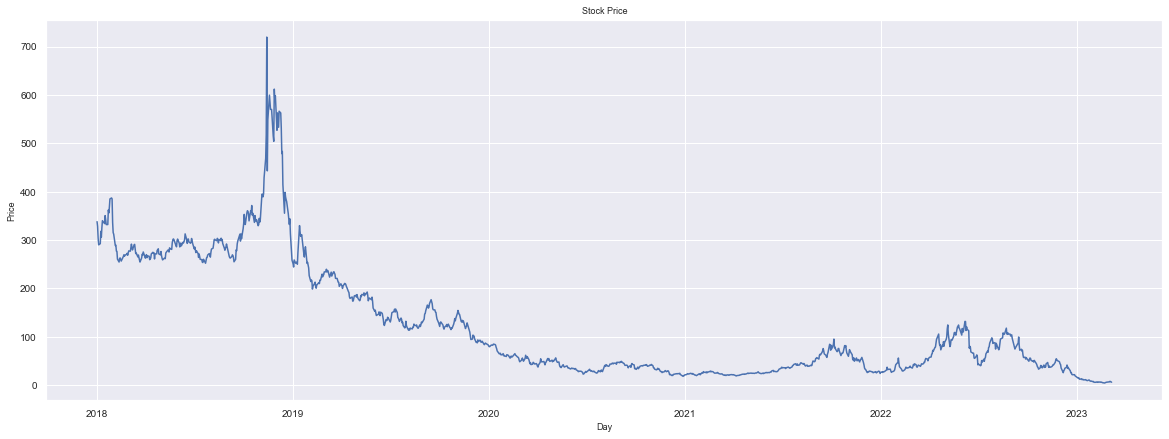

In [106]:
# plot target variable over time
fig, ax = plt.subplots(figsize=(20, 7))
sns.set_style('darkgrid')
sns.color_palette("tab10")

sns.lineplot(data=df, x=df.index, y='close', legend='full')

ax.set_xlabel("Day")
ax.set_ylabel("Price")
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Stock Price");

In [107]:
# check correlation of features with power consumption
corr = df.corr(method='pearson')
power_corr = pd.DataFrame(corr['future'].sort_values(ascending=False))
print(power_corr)

                  future
future          1.000000
lowerband       0.920634
low             0.919038
open            0.914589
hlc3            0.914438
close           0.914084
adjclose        0.914084
sma3            0.913682
ema1            0.912264
ema2            0.910315
high            0.909246
ema3            0.908185
previous_close  0.906198
upperband       0.868314
sma20           0.839326
atr             0.496985
high-low        0.480966
tr              0.444046
high-pc         0.383788
low-pc          0.345762
MACD            0.102313
wema3           0.089512
in_uptrend      0.087785
kst             0.079833
wema2           0.073189
momentum        0.066270
rsi             0.063565
wema1           0.052055
SMArsi          0.046340
drsi            0.045967
ROC10           0.045754
dprice          0.031620
Month           0.015801
percc1          0.015442
WeekDay        -0.002726
perc1c2        -0.011531
dvolume        -0.027301
volmom         -0.153598
volume         -0.240298


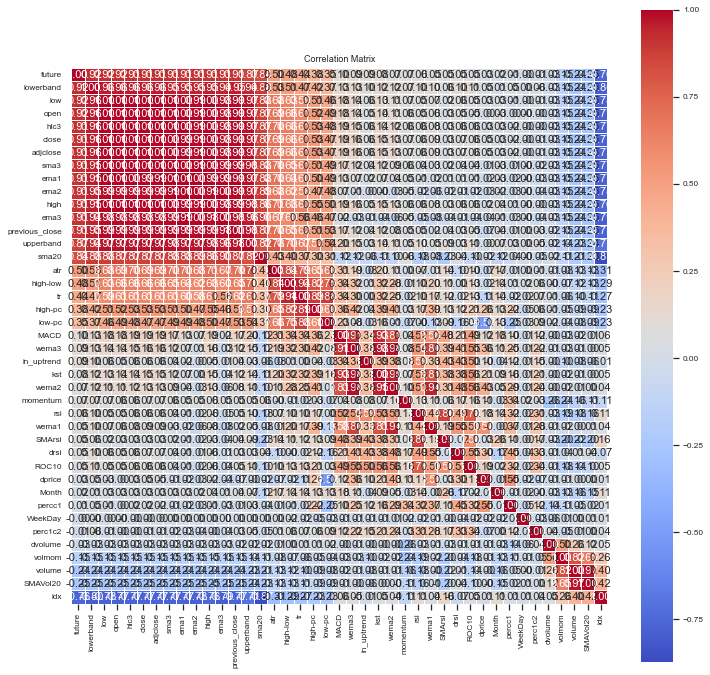

In [108]:
# create correlation matrix
corr_idx = df.corr().sort_values("future", ascending=False).index
corr_sorted = df.loc[:, corr_idx]  

plt.figure(figsize = (12,12))
sns.set(font_scale=0.75)
ax = sns.heatmap(corr_sorted.corr().round(3), annot=True, square=True, linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("Correlation Matrix")
plt.show()

## Prepare data for TFT model

In [112]:
# create Time Series Dataset Objects
lookback = LOOKUP_STEP * 5
prediction_length = LOOKUP_STEP

train_split = df["idx"].max() - prediction_length

training = TimeSeriesDataSet(df[lambda x: x.idx <= train_split], time_idx="idx", target="close", group_ids=["ticker"], 
                             min_encoder_length=lookback // 2, max_encoder_length=lookback, min_prediction_length=1, 
                             max_prediction_length=prediction_length, static_categoricals=["ticker"], time_varying_known_reals=["idx"],
                             time_varying_unknown_reals=FEATURE_COLUMNS, 
                             target_normalizer=GroupNormalizer(groups=["ticker"], transformation="softplus"), add_relative_time_idx=True, 
                             add_target_scales=True, add_encoder_length=True)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [113]:
df.shape

(1302, 43)

In [114]:
# create our data loaders
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

## Pytorch Lightning Trainer & TFT Model

In [115]:
# define our Pytorch Lightning Trainer & Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("logs")  

epochs = 50
trainer = pl.Trainer(max_epochs=epochs, accelerator='gpu', devices=1, enable_model_summary=True, gradient_clip_val=0.1, 
                     callbacks=[lr_logger, early_stop_callback], logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [116]:
# create our TFT model
tft = TemporalFusionTransformer.from_dataset(training, learning_rate=0.001, hidden_size=128, attention_head_size=4, 
                                             dropout=0.1, hidden_continuous_size=128,
                                             output_size=7, loss=QuantileLoss(), reduce_on_plateau_patience=4)

C:\Anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [117]:
# fit the model to the training data
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 7.7 K 
4  | static_variable_selection          | Va

Sanity Checking: 0it [00:00, ?it/s]

C:\Anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 22.485


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.190 >= min_delta = 0.0001. New best score: 14.295


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.642 >= min_delta = 0.0001. New best score: 11.653


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.930 >= min_delta = 0.0001. New best score: 7.723


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.908 >= min_delta = 0.0001. New best score: 4.815


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.724 >= min_delta = 0.0001. New best score: 4.091


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.113 >= min_delta = 0.0001. New best score: 2.978


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.567 >= min_delta = 0.0001. New best score: 1.412


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Anaconda3\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [118]:
# determine the best model checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)

logs\lightning_logs\version_0\checkpoints\epoch=11-step=480.ckpt


In [119]:
# load the best model from the saved checkpoints
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

## Review Model Results and Predictions

In [120]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir "logs"

In [121]:
# evaluate predictions vs. actuals
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

# Mean Absolute Percentage Error (MAPE)
MAPE = MeanAbsolutePercentageError()
print('Mean Absolute Percentage Error (MAPE) - Validation Dataset ')
print("MAPE: {:.2f}".format(MAPE(actuals, predictions)))

Mean Absolute Percentage Error (MAPE) - Validation Dataset 
MAPE: 0.46


In [122]:
# predict on the validation set
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print('prediction shape:', raw_predictions['prediction'].shape)

prediction shape: torch.Size([1, 20, 7])


Stock Price


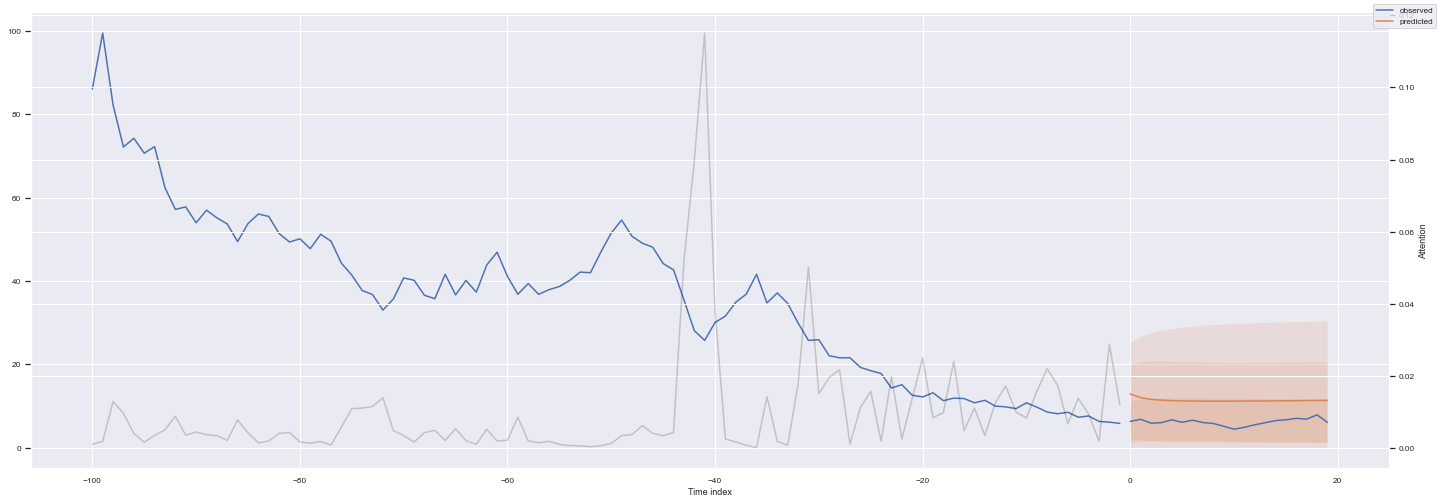

In [123]:
# view predictions by Zone
print("Stock Price")
for i in range(1):    
    fig, ax = plt.subplots(figsize=(20, 7))    
    best_tft.plot_prediction(x, raw_predictions, idx=i, ax=ax)

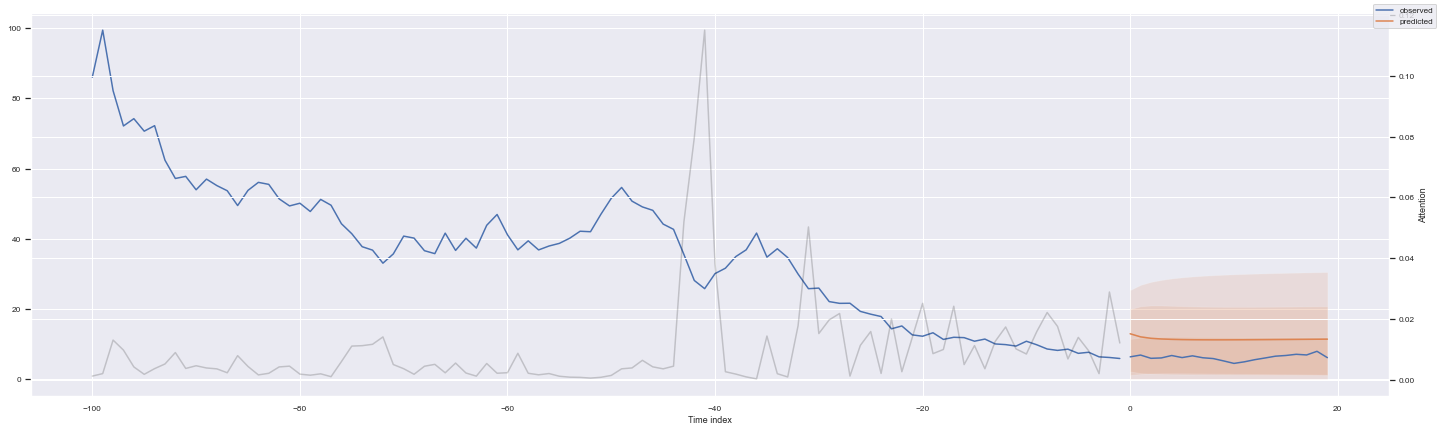

In [124]:
# plot for a specific time series
fig, ax = plt.subplots(figsize=(20, 6))
best_tft.plot_prediction(x, raw_predictions, idx=0, ax=ax);

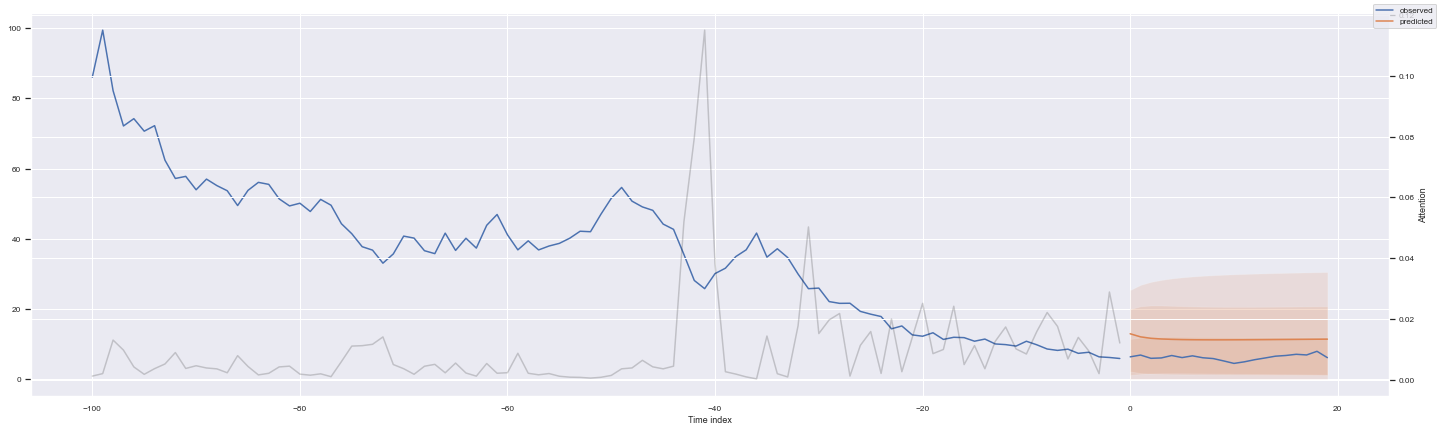

In [125]:
# plot for a specific time series
fig, ax = plt.subplots(figsize=(20, 6))
best_tft.plot_prediction(x, raw_predictions, idx=0, ax=ax);

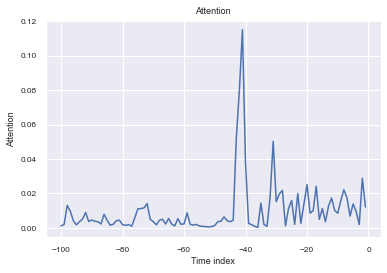

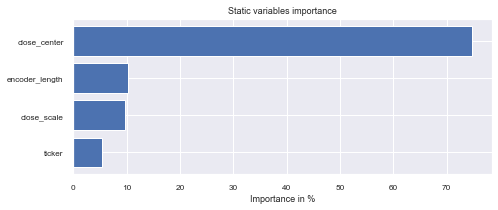

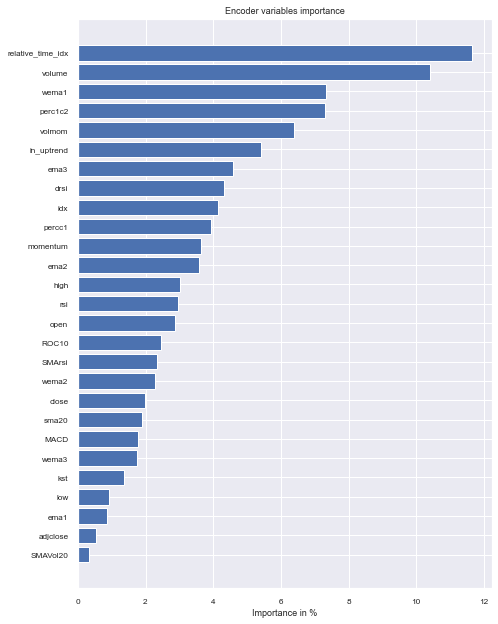

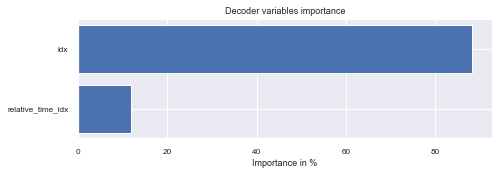

In [126]:
# feature level interpretability
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation);

## Create Out of Sample Forecast

In [127]:
# create decoder data
encoder_data = final_df[lambda x: x.idx > x.idx.max() - lookback]
encoder_data

NameError: name 'final_df' is not defined

In [ ]:
# our last validation data points
last_data = final_df[lambda x: x.idx == x.idx.max()]
last_data

In [ ]:
# create decoder dataframe template 
decoder_data = last_data.loc[last_data.index.repeat(24)].reset_index(drop=True)
decoder_data.shape

In [ ]:
decoder_data

In [ ]:
# now create our combined prediction dataset dataframe
new_pred_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_pred_data

In [ ]:
# make & plot out of sample predictions
inf_raw_predictions, inf_x = best_tft.predict(new_pred_data, mode="raw", return_x=True)

for i in range(1):    
    fig, ax = plt.subplots(figsize=(20, 7))
    best_tft.plot_prediction(inf_x, inf_raw_predictions, show_future_observed=False, idx=i, ax=ax)